# Bayesian Modeling of X-ray spectrum

We introduce the pyBlocxs with the default MCMC samplers in Sherpa, including standard Bayesian methods for exploring parameter space and the addition of the calibration uncertainties. The algorithms are published in the following articles:

Van Dyk, et al. (2001), *Analysis of Energy Spectra with Low Photon Counts via Bayesian Posterior Simulation*
https://ui.adsabs.harvard.edu/abs/2001ApJ...548..224V/abstract


Lee et al (2011),  *Accounting for Calibration Uncertainties in X-ray Analysis: Effective Areas in Spectral Fitting*
https://ui.adsabs.harvard.edu/abs/2011ApJ...731..126L/abstract

Xu et al (2014), *A Fully Bayesian Method for Jointly Fitting Instrumental Calibration and X-Ray Spectral Models*
 https://ui.adsabs.harvard.edu/abs/2014ApJ...794...97X/abstract

---------------------------------------------------------------------------------

This notebook works in CIAO 4.13

First import Sherpa 

In [1]:
from sherpa.astro.ui import *

We are only working with spectra, so imaging with ds9 will not be shown. We will use "matplotlib" for visualization. This is the default package for plotting in Sherpa.

We use the Poisson likelihood statistics called "cash" in Sherpa and select an optimization method for the initial fit - nelder-mead simplex algorithm.

In [2]:
set_stat('cash')
set_method('neldermead')

Next load the data, filter and setup a simple absorbed power law model. Note that the calibration files, ARF and RMF,  which are needed for the X-ray analysis and a background fileare read and when the file "acis.pi" is loaded into the session. 

In [3]:
load_data("acis.pi")
ignore(":0.5,7.0:")
set_model(xsphabs.abs1*xspowerlaw.p1)

read ARF file acis.arf
read RMF file acis.rmf
read background file acis_bg.pi


Run the initial fit using simplex and cash. This returns the best fit model parameters, absorption column, power law photon index and normalization.

In [4]:
fit()

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 3.15508e+07
Final fit statistic   = -89797.1 at function evaluation 540
Data points           = 444
Degrees of freedom    = 441
Change in statistic   = 3.16406e+07
   abs1.nH        0.0716477   
   p1.PhoIndex    1.17604     
   p1.norm        0.000533859 


Next get the covariance matrix with covar(). The matrix is later used in the MCMC run.

In [5]:
covar()

Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   abs1.nH         0.0716477  -0.00811361   0.00811361
   p1.PhoIndex       1.17604   -0.0242164    0.0242164
   p1.norm       0.000533859 -1.37268e-05  1.37268e-05


Plot the model and the data. 

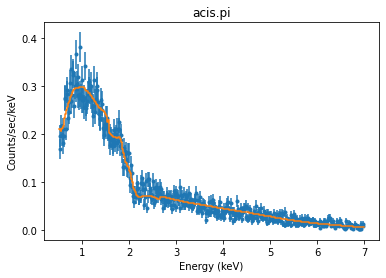

In [6]:
plot_fit()

### Setup MCMC sampler and priors

There are a few MCMC samplers in Sherpa that can be used to explore the parameter space. All are based on the Metropolis and Metropolis-Hastings algorithms. The standard `metropolismh` runs MCMC with Metropolis-Metropolis-Hastings criterium for accepting parameters.

In [7]:
list_samplers()

['metropolismh', 'mh', 'pragbayes', 'fullbayes']

Select MetropolisMH and check the options:

In [8]:
set_sampler("MetropolisMH")
get_sampler()

{'log': False,
 'inv': False,
 'defaultprior': True,
 'priorshape': False,
 'priors': (),
 'originalscale': True,
 'scale': 1,
 'sigma_m': False,
 'p_M': 0.5}

Here we list several options for running the MCMC sampler: 

defaultprior – indicates that all parameters have the default flat prior in Sherpa

inv – indicates which parameters are on the inverse scale.

log – indicates which parameters are on the logarithm scale (natural log).

originalscale –  shows that the parameters are on the original scale for a given parameter

p_M – the proportion of jumps generated by the MCMC jumping rule.

priorshape –  indicates which parameters have user-defined prior functions.

scale – A scalar multiple of the output of covar() used in the scale of the t-distribution


We first run the MCMC with the default settings. `get_draws` is the function which runs the chains.

In [9]:
help(get_draws)

Help on function get_draws in module sherpa.astro.ui:

get_draws(id=None, otherids=(), niter=1000, covar_matrix=None)
    Run the pyBLoCXS MCMC algorithm.
    
    The function runs a Markov Chain Monte Carlo (MCMC) algorithm
    designed to carry out Bayesian Low-Count X-ray Spectral
    (BLoCXS) analysis. It explores the model parameter space at
    the suspected statistic minimum (i.e.  after using `fit`). The return
    values include the statistic value, parameter values, and an
    acceptance flag indicating whether the row represents a jump from the
    current location or not. For more information see the
    `sherpa.sim` module and [1]_.
    
    Parameters
    ----------
    id : int or str, optional
       The data set that provides the data. If not given then
       all data sets with an associated model are used simultaneously.
    otherids : sequence of int or str, optional
       Other data sets to use in the calculation.
    niter : int, optional
       The number of dr

In [10]:
stats, accept, params = get_draws(niter=1e3)
# check the parameters at the minimum statistic value based on the sampler:

Using Priors:
abs1.nH: <function flat at 0x7ff2312fc670>
p1.PhoIndex: <function flat at 0x7ff2312fc670>
p1.norm: <function flat at 0x7ff2312fc670>


-------------------------------------------------

The stats array contains the fit statistic for each iteration (the first element of these arrays
is the starting point of the chain, so there will be 10001 elements in this case). 
We can check the minimum of the statistics for the best fit parameter values and the standard deviations.


In [11]:
bestfit = params[::,stats.argmin()].T
# print bestfit values and standard deviations
print(bestfit)
[params[i].std() for i in [0,1,2]]

[7.16476507e-02 1.17603887e+00 5.33858688e-04]


[0.007708456321037247, 0.022955572070114207, 1.3342403008224056e-05]

The traces of each arrays show the steps for the entire chain and can be plotted with the Sherpa default plotting functions.

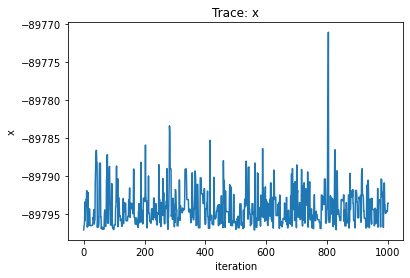

In [12]:
# visualization of the MCMC run - Cash at each iteration
plot_trace(stats)

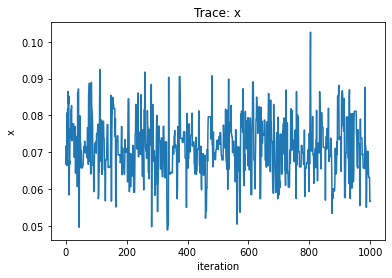

In [13]:
plot_trace(params[0])

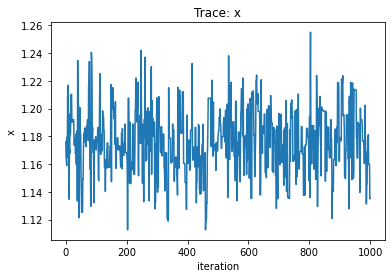

In [14]:
plot_trace(params[1]) 

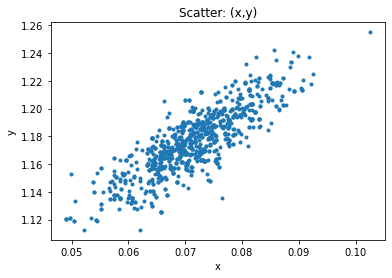

In [15]:
# dependence between parameters
plot_scatter(params[0],params[1])

The relation between the two parameters can be visualized as a scatter plot above.

The distributions for each parameter can be plotted as histograms and as a cummulative distributions which provides an easy way to access the median and upper/lower 1 sigma interval.

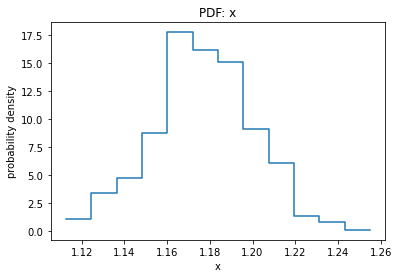

In [16]:
# plot the distribution for photon index gamma
plot_pdf(params[1])

1.176220928128069
1.1989846584438775
1.156263869252614


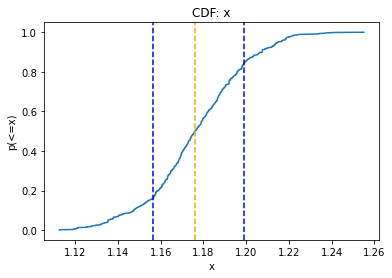

In [17]:
# plot the cummulative density for photon index, print the median and upper/lower confidence values.
plot_cdf(params[1])
print(get_cdf_plot().median)
print(get_cdf_plot().upper) 
print(get_cdf_plot().lower)      

In [18]:
bestfit1 = params[::,stats.argmin()].T
# print bestfit values and standard deviations
print(bestfit1)
[params[i].std() for i in [0,1,2]]

[7.16476507e-02 1.17603887e+00 5.33858688e-04]


[0.007708456321037247, 0.022955572070114207, 1.3342403008224056e-05]

## Changing Priors

Changing the prior for photon index to a gaussian prior. We use one of the predefined Sherpa model `normgauss1d` to set the prior.

In [19]:
normgauss1d.g1
g1.pos=2.
g1.fwhm=0.5
set_prior(p1.PhoIndex,g1)

Below, `set_sampler_opt` is used to set a prior for each parameter

In [20]:
set_sampler_opt('defaultprior',False)  # not using the default prior for each parameter
# below define the prior shape for p1.gamma, use default for abs.nH and p1.ampl
set_sampler_opt('priorshape', [False, True, False]) 
set_sampler_opt('originalscale', [True, True, True])# all prior is defined on the original parameter scale

In [21]:
# Run sampler
stats, accept, params = get_draws(niter=1e3)

Using Priors:
abs1.nH: <function flat at 0x7ff2312fc670>
p1.PhoIndex: normgauss1d.g1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   g1.fwhm      thawed          0.5  1.17549e-38  3.40282e+38           
   g1.pos       thawed            2 -3.40282e+38  3.40282e+38           
   g1.ampl      thawed            1 -3.40282e+38  3.40282e+38           
p1.norm: <function flat at 0x7ff2312fc670>


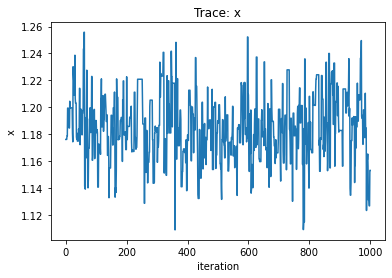

In [22]:
plot_trace(params[1])

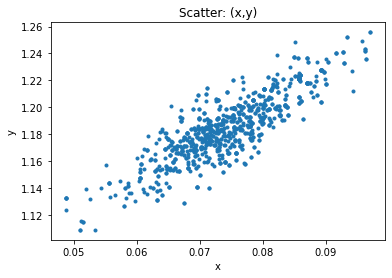

In [23]:
plot_scatter(params[0],params[1])

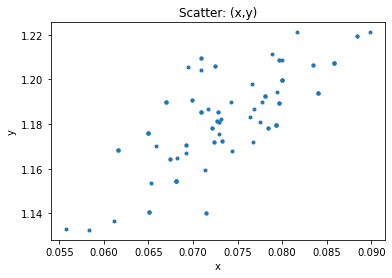

In [24]:
plot_scatter(params[0][100:200],params[1][100:200])

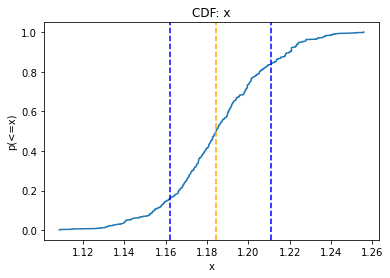

In [25]:
plot_cdf(params[1])

In [26]:
print(get_cdf_plot().median)
print(get_cdf_plot().upper) 
print(get_cdf_plot().lower)

1.1845307095043711
1.211167826392162
1.1621568846734065


In [27]:
bestfit1 = params[::,stats.argmin()].T
# print bestfit values and standard deviations
print(bestfit1)
[params[i].std() for i in [0,1,2]]

[7.38638019e-02 1.18463750e+00 5.38155302e-04]


[0.008279386702399395, 0.024729391151673632, 1.4244726633682999e-05]

## Take calibration uncertainties into account

If the uncertainties on the ARF are provided then they can be included in the evaluation of the best fit parameters via MCMC.

This is the standard loop for running MCMC  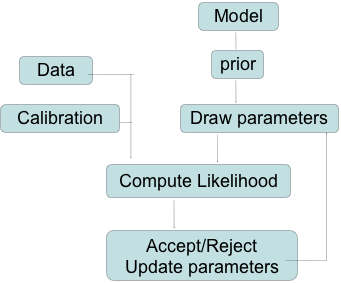

Here we include the additional step to incorporate draws from the calibration data 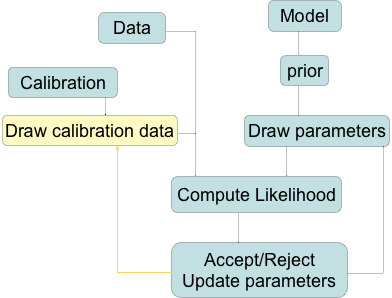

`pragbayes` sampler will include this step if the required data is available.

In [28]:
set_sampler('pragbayes')
get_sampler()  # information about the available options - Note simarf and nsubiters.

{'log': False,
 'inv': False,
 'defaultprior': True,
 'priorshape': False,
 'priors': (),
 'originalscale': True,
 'scale': 1,
 'sigma_m': False,
 'p_M': 0.5,
 'simarf': None,
 'nsubiters': 10}

In [29]:
set_sampler_opt('simarf', 'aref_Cedge.fits')
set_sampler_opt('nsubiters',5)

In [30]:
get_sampler()

{'log': False,
 'inv': False,
 'defaultprior': True,
 'priorshape': False,
 'priors': (),
 'originalscale': True,
 'scale': 1,
 'sigma_m': False,
 'p_M': 0.5,
 'simarf': 'aref_Cedge.fits',
 'nsubiters': 5}

In [31]:
print(get_model())

apply_rmf(apply_arf((27358.24455786 * (xsphabs.abs1 * xspowerlaw.p1))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   abs1.nH      thawed    0.0716477            0       100000 10^22 atoms / cm^2
   p1.PhoIndex  thawed      1.17604           -2            9           
   p1.norm      thawed  0.000533859            0        1e+24           


In [32]:
stat_sim, accept_sim, params_sim = get_draws(niter=1e3)

Using Priors:
abs1.nH: <function flat at 0x7ff2312fc670>
p1.PhoIndex: normgauss1d.g1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   g1.fwhm      thawed          0.5  1.17549e-38  3.40282e+38           
   g1.pos       thawed            2 -3.40282e+38  3.40282e+38           
   g1.ampl      thawed            1 -3.40282e+38  3.40282e+38           
p1.norm: <function flat at 0x7ff2312fc670>
Draw rejected: parameter boundary exception: [-1.99466812e-02  8.99252054e-01  4.32438144e-04]
Draw rejected: parameter boundary exception: [-9.88342308e-02  7.28437628e-01  2.99137917e-04]


----------------------------------------------------------

Display the PDF for Photon index (gamma) from the MCMC with a default calibration file and from PragBayes with draws from the calibration data.

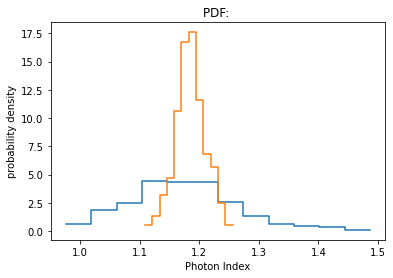

In [33]:
plot_pdf(params_sim[1], name='', xlabel = 'Photon Index')
plot_pdf(params[1], name='', xlabel = 'Photon Index',overplot =True,clearwindow=False)

-----------------------------------------------------------------------------

Display Photon Index values obtained with the default calibration and compare to the PragBayes values with the draws from calibration data. 

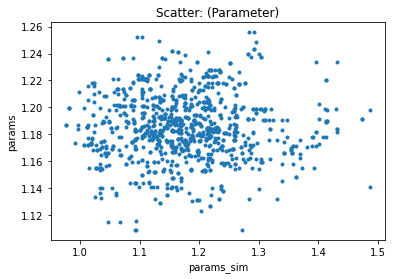

In [34]:
plot_scatter(params_sim[1],params[1][0:1001], name="(Parameter)", xlabel="params_sim", ylabel="params")

In [35]:
len(params_sim[0])

1001

## Full Bayes - modeling ARF

This is an experimental function in Sherpa to include both fitting of the model and the calibration data (finding the best ARF within a calibration uncertainties). The algorithm is described in 
Xu et al (2014), A Fully Bayesian Method for Jointly Fitting Instrumental Calibration and X-Ray Spectral Models https://ui.adsabs.harvard.edu/abs/2014ApJ...794...97X/abstract




In [36]:
print(list_samplers())

['metropolismh', 'mh', 'pragbayes', 'fullbayes']


In [37]:
set_sampler('fullbayes')

In [38]:
get_sampler()

{'log': False,
 'inv': False,
 'defaultprior': True,
 'priorshape': False,
 'priors': (),
 'originalscale': True,
 'scale': 1,
 'sigma_m': False,
 'p_M': 0.5,
 'simarf': None,
 'p_M_arf': 0.5,
 'sigma_arf': 0.1}

In [39]:
set_sampler_opt('simarf','aref_Cedge.fits')

In [40]:
stat_sim1, accept_sim1, params_sim1 = get_draws(niter=1e3)

Using Priors:
abs1.nH: <function flat at 0x7ff2312fc670>
p1.PhoIndex: normgauss1d.g1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   g1.fwhm      thawed          0.5  1.17549e-38  3.40282e+38           
   g1.pos       thawed            2 -3.40282e+38  3.40282e+38           
   g1.ampl      thawed            1 -3.40282e+38  3.40282e+38           
p1.norm: <function flat at 0x7ff2312fc670>
Draw rejected: parameter boundary exception: [-9.98918103e-04  1.00637732e+00  4.48082558e-04]
Draw rejected: parameter boundary exception: [-6.16929812e-02  7.60192563e-01  3.46722396e-04]


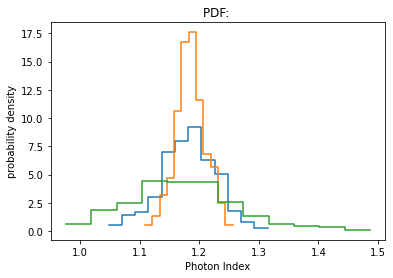

In [41]:
plot_pdf(params_sim1[1], name='', xlabel = 'Photon Index')
plot_pdf(params[1], name='', xlabel = 'Photon Index',overplot =True,clearwindow=False)
plot_pdf(params_sim[1], name='', xlabel = 'Photon Index',overplot =True,clearwindow=False)

In [42]:
# Use the python package from Dan Foreman-Mackey https://github.com/dfm/corner.py to make a corner plots
import corner

In [49]:
parvals = [p.val for p in get_model().pars if not p.frozen]
print(parvals)

[0.07164765072846567, 1.176038869172598, 0.0005338586882594435]


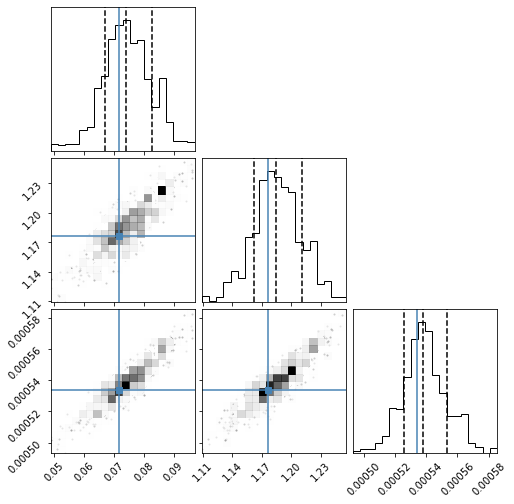

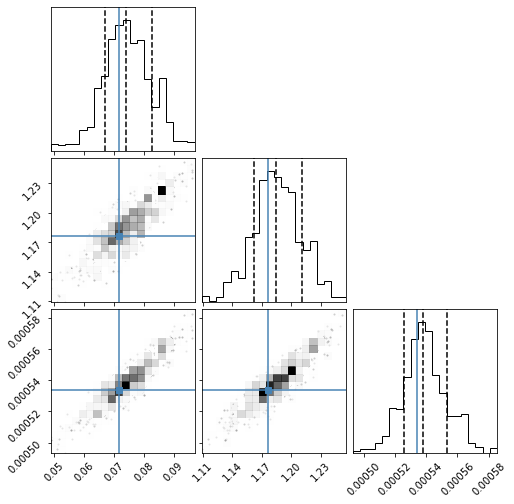

In [63]:
corner.corner(params[:].T, 
              quantiles=[0.16, 0.5, 0.84],
              plot_contours=False, truths=parvals)

In [62]:
params.shape

(3, 1001)